# IMPORT LIBRARIES

In [1]:
import torch
import torch.nn as nn
import plotly.express
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import  Button, Slider
import plotly.graph_objects as go
import math
import cv2
from PIL import Image
from ipywidgets import interact, fixed, widgets, interact_manual

# SHOW IMAGE IN UINT8

In [2]:
def show_img_and_filter(x):
    return Image.fromarray(np.array(x).astype(np.uint8))

# TTFS ENCODING

In [3]:
class TimeToFirstSpike():

    def __init__(self,img, time_window):
        self.img = img
        self.img_show = self.img.clone()
        self.img = cv2.resize(np.array(self.img), (224,224))
        self.img = torch.from_numpy(self.img)
        self.time_window = time_window

    def encode(self):
        self.img = abs(self.img - 255) *(self.time_window-1) // 255
        # print(self.img.max(), self.img.min())
        self.spikes = torch.Tensor(self.time_window, *self.img.size(), device="cpu")
        for time in range(self.time_window):
            spikes_bool = self.img == time
            self.spikes[time] = spikes_bool
        return self.spikes.view(self.time_window, self.img.shape[0]*self.img.shape[1])
    
    def raster_plot(self, spikes):
        self.spikes = spikes
        plt.figure(figsize=(20,8))
        plt.scatter(torch.nonzero(self.spikes, as_tuple=True)[0], torch.nonzero(self.spikes, as_tuple=True)[1])
        plt.xlabel("Time")
        plt.ylabel("Neurons")
        plt.title('Raster Plot')
        plt.xlim(-1,self.time_window)
        plt.show()

# POISSON ENCODING

In [4]:
class Poisson():
    
    def __init__(self, time_window, r):
        self.time_window = time_window
        self.r = r
        
    def encode(self, img):
        img = torch.from_numpy(cv2.resize(np.array(img), (224,224)))
        img = img - img.min()
        img /= img.max()
        p_rand = torch.rand(size=(self.time_window, img.shape[0] , img.shape[1]))
        spikes = torch.cat([img.unsqueeze(0)]*self.time_window) * self.r
        self.encode_spikes = (spikes >= p_rand).byte()
        return self.encode_spikes.view(self.time_window, img.shape[0]*img.shape[1])
    
    def raster_plot(self):
        plt.figure(figsize=(20,8))
        plt.scatter(torch.nonzero(self.encode_spikes, as_tuple=True)[0], torch.nonzero(self.encode_spikes, as_tuple=True)[1])
        plt.xlabel("Time")
        plt.ylabel("Neurons")
        plt.title('Poisson Encoding')
        plt.xlim(-1,self.time_window)
        plt.show()

# DOG FILTERS

In [5]:
class DoG():
    
    def __init__(self, sigma1, sigma2, kernel_size=3, stride=1, mode="on_center_off_surround"):
        self.sigma1 = sigma1
        self.sigma2 = sigma2
        self.kernel_size = kernel_size
        self.stride = stride
        self.mode = mode
        self.dict_mode = {"on_center_off_surround": 1, "off_center_on_surround": -1}
    
    def DoGFilter(self):
        self.filt = torch.zeros((self.kernel_size, self.kernel_size))
        for i in range(self.kernel_size):
            for j in range(self.kernel_size):
                x = i
                y = j
                x = x - (self.kernel_size - 1) / 2
                y = y - (self.kernel_size - 1) / 2
                sum_x_y = -1 * ((x**2) + (y**2)) / 2
                dog1 = (np.e ** (sum_x_y / (self.sigma1**2))) / self.sigma1
                dog2 = (np.e ** (sum_x_y / (self.sigma2**2))) / self.sigma2
                self.filt[i][j] = (1 / np.sqrt(2 * np.pi)) * (dog1 - dog2) * self.dict_mode[self.mode]
        mean_filt = torch.sum(self.filt) / (self.kernel_size * self.kernel_size)
        self.filt -= mean_filt
        return self.filt
    
    def show_filter(self, name = "DoGFilter"):
        filter_show = self.filt
        filter_show = filter_show - filter_show.min()
        filter_show = filter_show / filter_show.max()
        filter_show = filter_show * 255
        filter_show = cv2.resize(np.array(filter_show), (224, 224))
        return show_img_and_filter(filter_show)
        
    def show_convolved_image(self, img, name="convDoGImg"):
        image = img.clone()
        image -= image.min()
        image /= image.max()
        image *= 255
        # image = abs(255 - image)
        return show_img_and_filter(image)
    
    def convolve_DoG(self, img):
        pad = (self.kernel_size-1)//2
        image = torch.nn.functional.pad(input=img, pad=[pad, pad, pad, pad])
        
        final_img = torch.zeros(img.shape[0]//self.stride, img.shape[1]// self.stride)
        stride_x = 0
        for i in range(final_img.shape[0]):
            stride_y = 0
            for j in range(final_img.shape[1]):
                
                # final_img[i][j] = torch.dot(torch.flatten(img[stride_x:stride_x+self.kernel_size,
                #                                               stride_y:stride_y+self.kernel_size]).float(),
                #                             torch.flatten(self.filt))
                
                final_img[i][j] = torch.sum(image[stride_x:stride_x+self.kernel_size, stride_y:stride_y+self.kernel_size] * self.filt)#, dtype=torch.uint8)
                stride_y += self.stride
            stride_x += self.stride
            
        # final_img = torch.nn.functional.conv1d(torch.unsqueeze(img, dim=0), torch.unsqueeze(self.filt, dim=0), stride=self.stride, padding=pad)
        # final_img = final_img.type('torch.ByteTensor')
        return final_img

# READIN ORIGINAL IMAGE AND CONVERT IT TO GRAY SCALE IMAGE

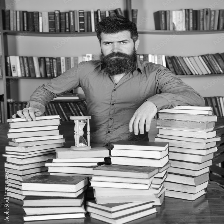

In [6]:
image_path = "face_books.jpeg"
img_orginal = Image.open(image_path).convert('L')
# cv2.imwrite("project7_assets/original.png", np.array(img_orginal))
img_orginal = cv2.resize(np.array(img_orginal), (224, 224))
img_orginal = np.array(img_orginal, 'f')
img_orginal = torch.from_numpy(img_orginal)
show_img_and_filter(img_orginal)

# MAKING DoG FILTER AND SHOW IT

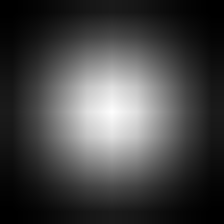

In [7]:
dog = DoG(sigma1=2, sigma2=9, kernel_size=9)
dog_filter = dog.DoGFilter()
dog.show_filter()

# CONVOLVE FILTER ON THE ORIGINAL IMAGE

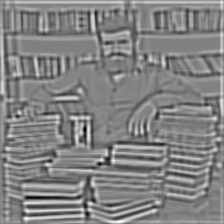

In [8]:
convolved_img = dog.convolve_DoG(img_orginal)
dog.show_convolved_image(convolved_img)

# TTFS ENCODING OF CONVOLVED IMAGE WITH TIME WINDOW OF 10

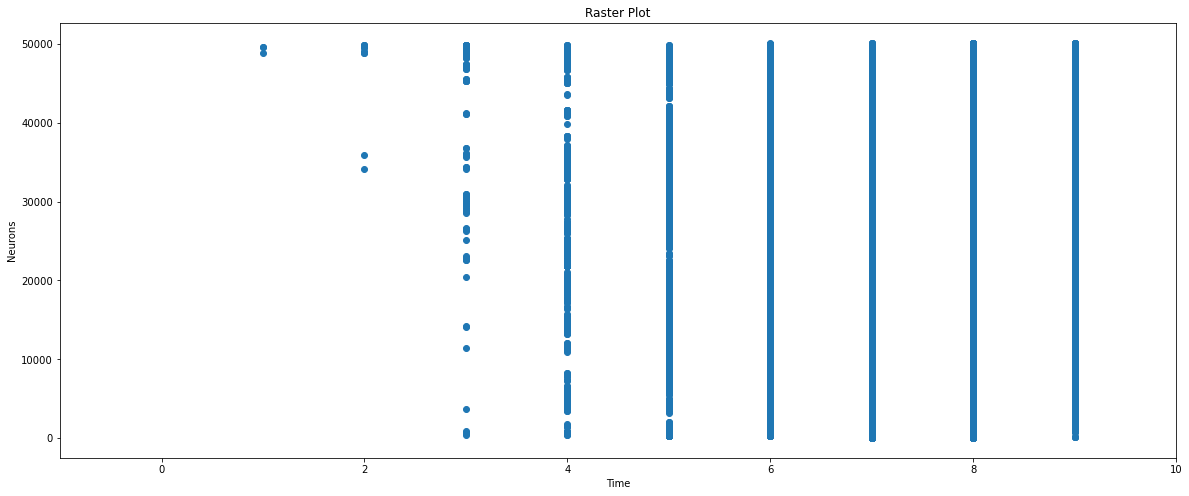

In [9]:
time_window = 10
obj = TimeToFirstSpike(convolved_img, time_window)
spikes = obj.encode()
obj.raster_plot(spikes)

# SPIKES IN EVERY ITERATION OF TTFS ENCODING

In [10]:
def ttfs_step(firings):
    firings = firings.view(10, 224, 224)
    firings *= 255
    firings = abs(firings - 255)
    
    fig, axs = plt.subplots(2,5, figsize=(15, 6))
    # fig.subplots_adjust(hspace = .5, wspace=.001)

    axs = axs.ravel()

    for i in range(time_window):
        step = np.array(firings[i])
        if (step - 255).sum() == 0:
            axs[i].imshow(torch.zeros((224, 224)), cmap='binary')
            axs[i].set_title('iteration' + str(i))
        else:
            axs[i].imshow(step, cmap='gray')
            axs[i].set_title('iteration' + str(i))

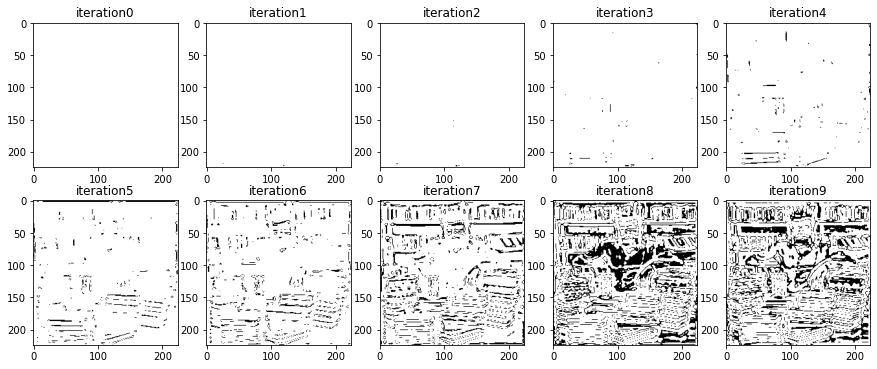

In [11]:
ttfs_step(spikes)

# POISSON ENCODING OF CONVOLVED IMAGE

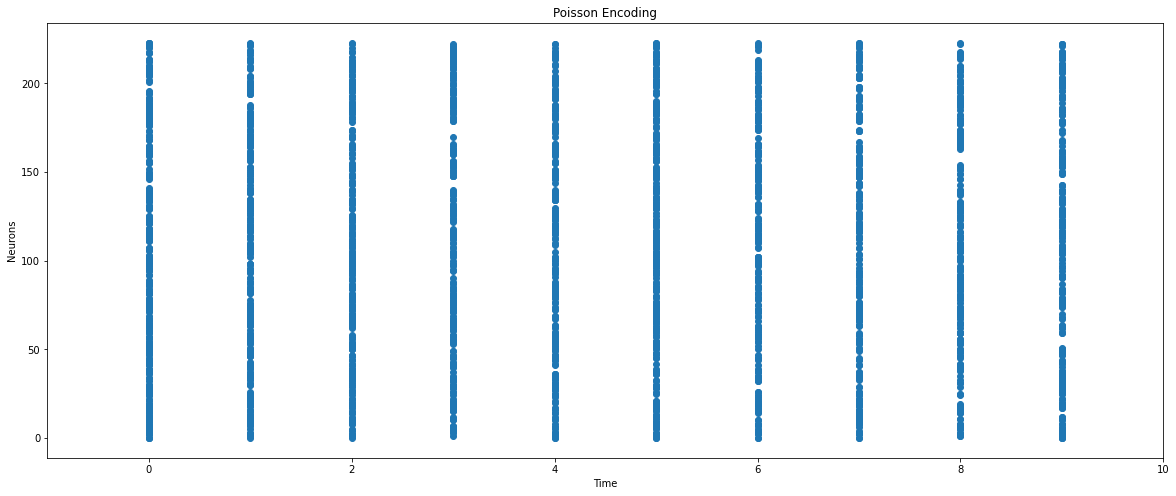

In [12]:
encode = Poisson(10, r=0.01)
spikes_poisson = encode.encode(convolved_img)
encode.raster_plot()

# **WE DO ALL THE WORK ABOVE FOR OFF-CENTER-ON-SURROUND FILTER**

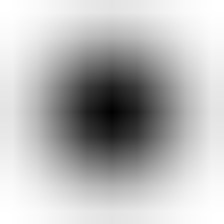

In [13]:
dog = DoG(sigma1=2, sigma2=9, kernel_size=9, mode="off_center_on_surround")
dog_filter = dog.DoGFilter()
dog.show_filter(name="DoGFilterOff")

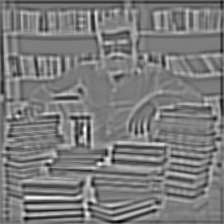

In [14]:
convolved_img = dog.convolve_DoG(img_orginal)
dog.show_convolved_image(convolved_img,name="convDoGImgOff")

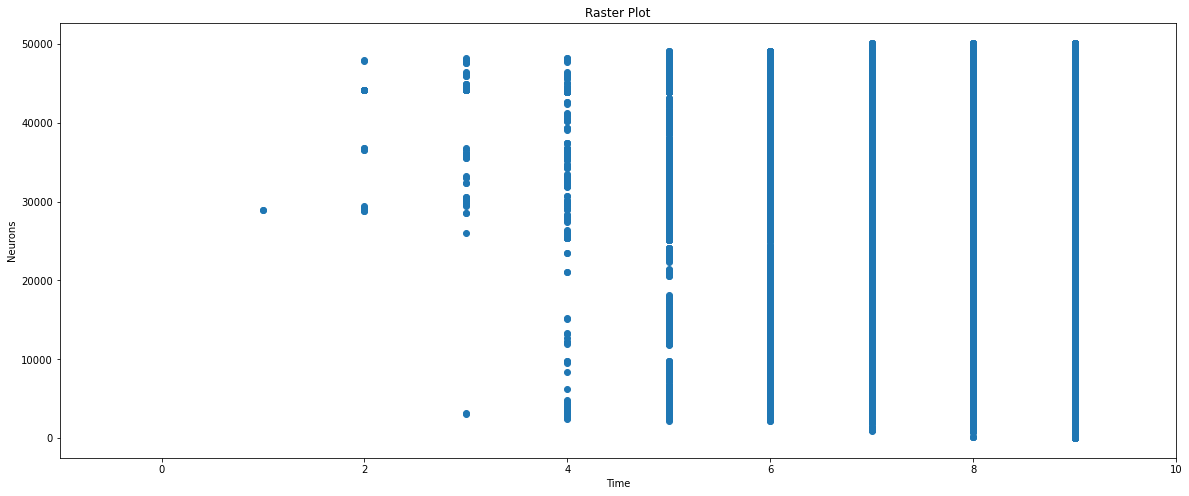

In [15]:
time_window = 10
obj = TimeToFirstSpike(convolved_img, time_window)
spikes = obj.encode()
obj.raster_plot(spikes)

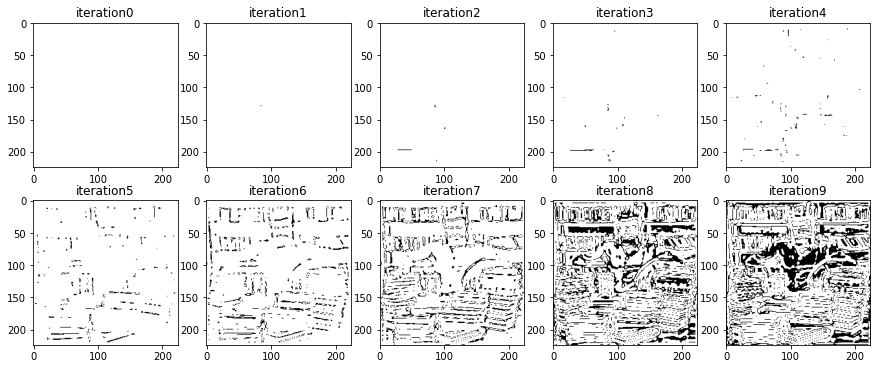

In [16]:
ttfs_step(spikes)

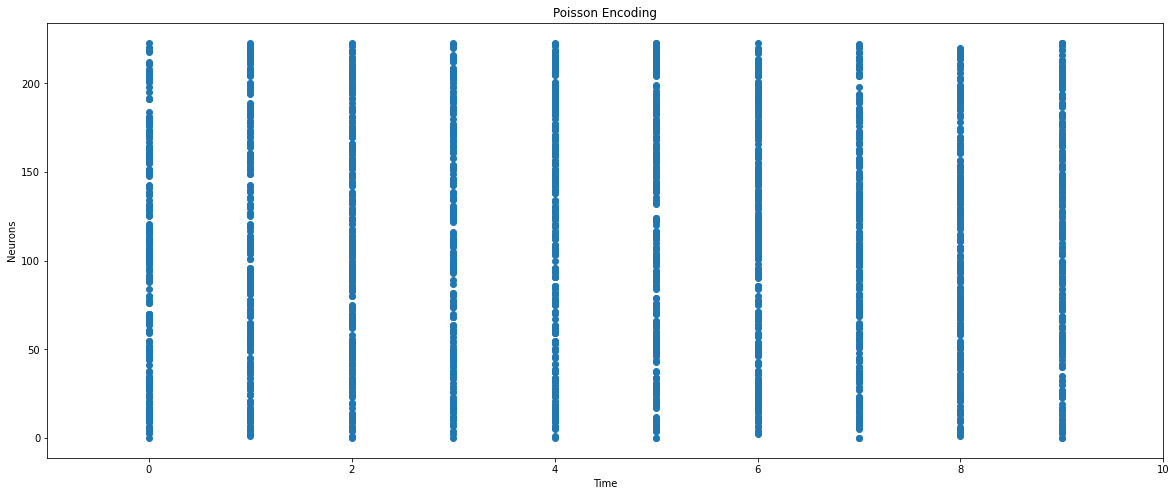

In [17]:
encode = Poisson(10, r=0.01)
spike_poisson = encode.encode(convolved_img)
encode.raster_plot()

# GABOR FILTER

In [18]:
class Gabor(DoG):
    
    def __init__(self, kernel_size, sigma, theta, landa, gamma, mode="on_center_off_surround", stride=1):
        self.sigma = sigma
        self.kernel_size = kernel_size
        self. stride = stride
        self.mode = mode
        self.dict_mode = {"on_center_off_surround": 1, "off_center_on_surround": -1}
        self.gamma = gamma
        self.theta = theta
        self.landa = landa
        
        self.theta = self.theta * np.pi / 180
        
    def GaborFilter(self):
        shape = self.kernel_size // 2 + 1
        y, x = np.meshgrid(np.arange(-self.kernel_size // 2 + 1, self.kernel_size // 2 + 1), 
                           np.arange(-self.kernel_size // 2 + 1, self.kernel_size // 2 + 1))
        # y, x = y * 10, x * 10

        x_ = np.cos(self.theta) * x + np.sin(self.theta) * y
        y_ = -x * np.sin(self.theta) + y * np.cos(self.theta)

        self.filt = torch.from_numpy(np.exp(-0.5 * (x_**2 + (self.gamma**2 * y_**2))/self.sigma**2)* np.cos(2*np.pi/self.landa * x_) * self.dict_mode[self.mode])
        mean_filt = torch.sum(self.filt) / (self.kernel_size * self.kernel_size)
        self.filt -= mean_filt
        return self.filt

# TEST DIFFERENT ORIENTATION OF GABOR FILTER

In [19]:
def circle_orientation(image):
    thetas = [0, 11.25, 22.5, 33.75, 45, 56.25, 67.5, 78.75, 90, 101.25, 112.5, 123.75, 135, 146.25, 157.5, 168.75]
    
    fig, axs = plt.subplots(8,4, figsize=(25, 25))
    # fig.subplots_adjust(hspace =0.4, wspace=0.0001)

    axs = axs.ravel()

    for i in range(len(thetas)):
        gabor = Gabor(kernel_size=5, sigma=4, theta=thetas[i], landa=5, gamma=0)
        filt_gabor = gabor.GaborFilter()
        filter_gabor = filt_gabor.clone()
        filter_gabor -= filter_gabor.min()
        filter_gabor /= filter_gabor.max()
        filter_gabor *= 255
        axs[i].imshow(filter_gabor, cmap='gray')
        axs[i].set_title('Theta: ' + str(thetas[i]))
        axs[i].tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
    for i in range(16, len(thetas)+16):
        gabor = Gabor(kernel_size=5, sigma=4, theta=thetas[i-16], landa=5, gamma=0)
        filt_gabor = gabor.GaborFilter()
        convolved_img = gabor.convolve_DoG(image)
        axs[i].imshow(convolved_img, cmap='gray')
        axs[i].tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)

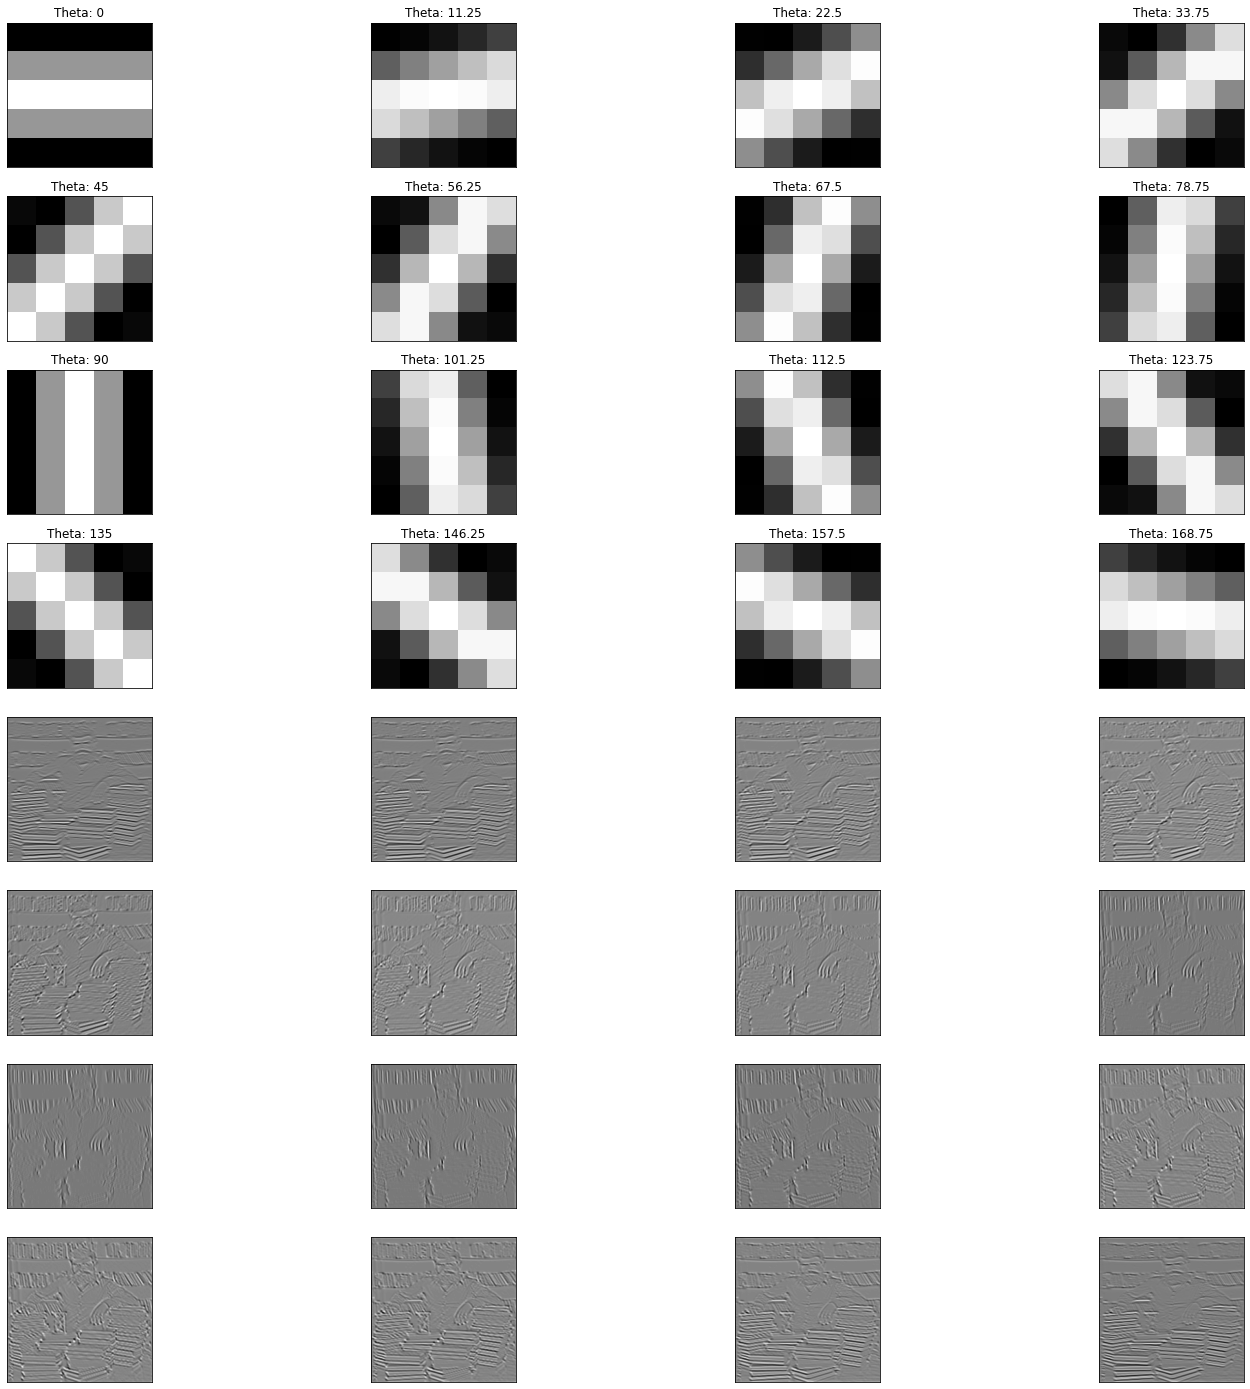

In [20]:
circle_orientation(img_orginal)

# CONSTRUCT GABOR FILTER

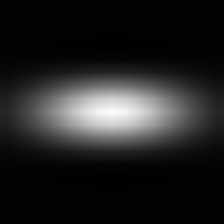

In [21]:
gabor = Gabor(kernel_size=17, sigma=2, theta=0, landa=16.3, gamma=0.5)
filter_gabor = gabor.GaborFilter()
gabor.show_filter(name="gaborFilterOn")

# CONVOLVE THIS GABOR FILTER ON THE ORIGINAL IMAGE

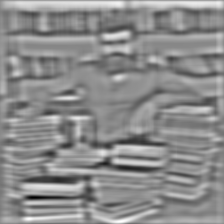

In [22]:
convolved_img = gabor.convolve_DoG(img_orginal)
gabor.show_convolved_image(convolved_img, name="convImgOn")

# TTFS ENCODING OF CONVOLVED IMAGE

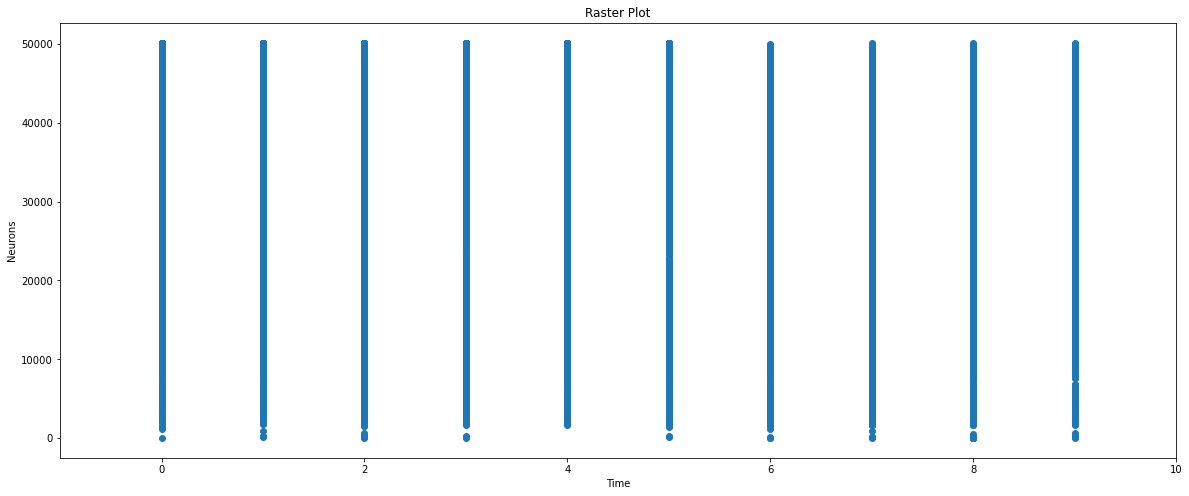

In [23]:
time_window = 10
obj = TimeToFirstSpike(convolved_img, time_window)
spikes= obj.encode()
obj.raster_plot(spikes)

# TTFS ENCODING STEPS

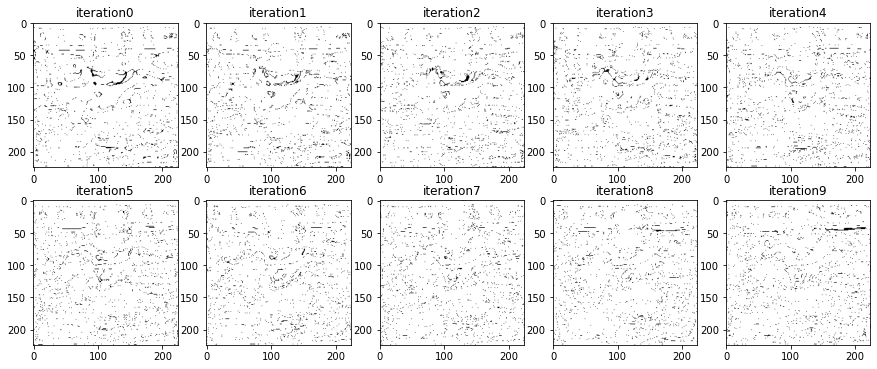

In [24]:
ttfs_step(spikes)

# POISSON ENCODING OF THE CONVOLVED IMAGE

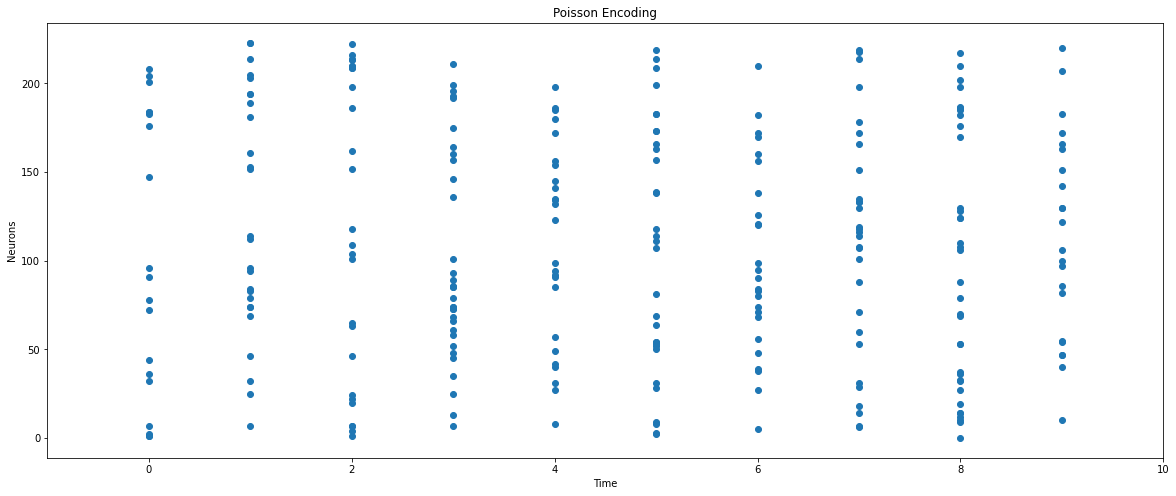

In [25]:
encode = Poisson(10, r=0.001)
pattern = encode.encode(convolved_img)
encode.raster_plot()

# OFF-CENTER-ON-SURROUND GABOR FILTER

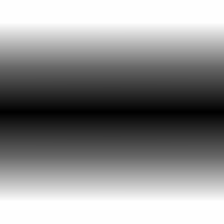

In [26]:
gabor = Gabor(kernel_size=5, sigma=4, theta=0, landa=5, gamma=0.1, mode="off_center_on_surround")
filter_gabor = gabor.GaborFilter()
gabor.show_filter(name="gaborFilterOff")

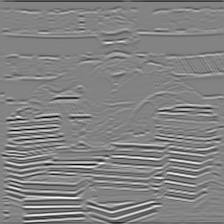

In [27]:
convolved_img = gabor.convolve_DoG(img_orginal)
gabor.show_convolved_image(convolved_img, name="convImgOff")

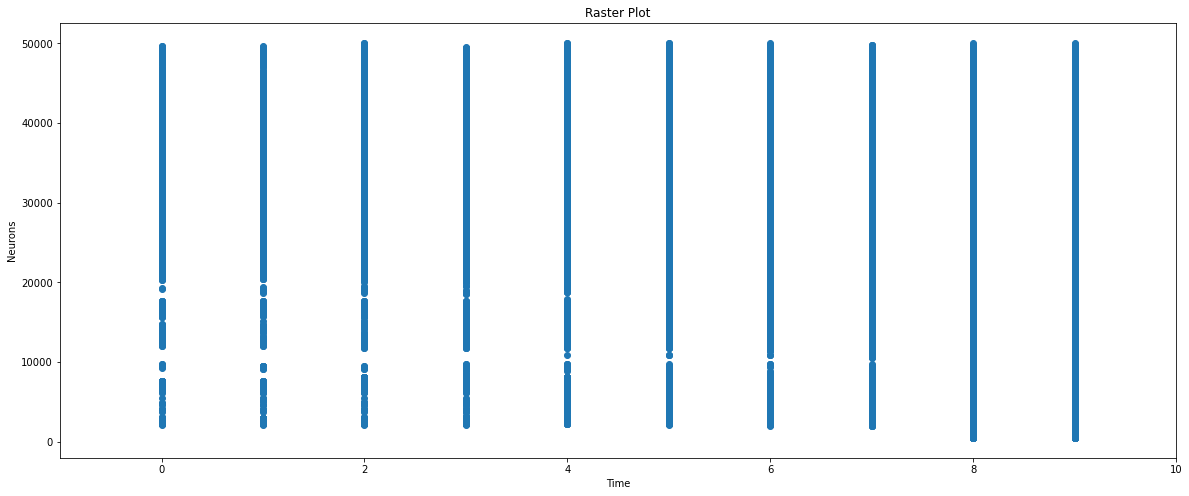

In [28]:
time_window = 10
obj = TimeToFirstSpike(convolved_img, time_window)
spikes = obj.encode()
obj.raster_plot(spikes)

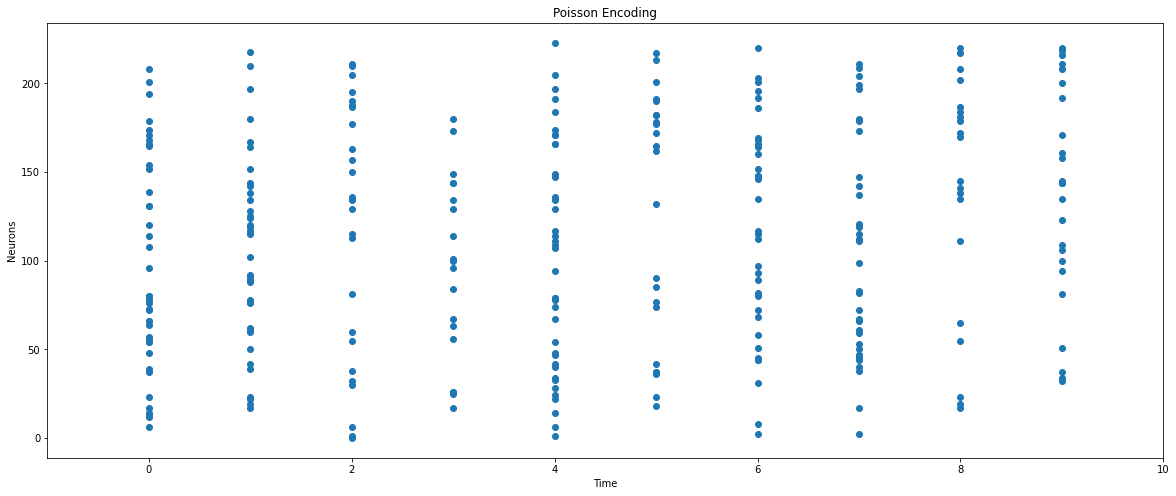

In [29]:
encode = Poisson(10, r=0.001)
pattern = encode.encode(convolved_img)
encode.raster_plot()

# INTERACTIVE GABOR FILTER

In [30]:
@interact(
    kernel_size=[3,5,7,9,11,13,15,17,33,65],
    landa=widgets.FloatSlider(min=0, max=20, step=0.1, value=5.), 
    theta=widgets.FloatSlider(min=-180, max=180, step=1, value=0.0),    
    sigma=widgets.FloatSlider(min=0, max=20, step=0.1, value=5.),
    gamma=widgets.FloatSlider(min=0, max=10, step=0.1, value=0.1))

def gabor_interactive(kernel_size, landa, theta, sigma, gamma):
    gabor = Gabor(kernel_size=kernel_size, sigma=sigma, theta=theta, landa=landa, gamma=gamma)
    filt_gabor = gabor.GaborFilter()
    filter_gabor = filt_gabor.clone()
    filter_gabor -= filter_gabor.min()
    filter_gabor /= filter_gabor.max()
    filter_gabor *= 255
    filter_gabor = cv2.resize(np.array(filter_gabor), (224, 224))
    convolved_img = gabor.convolve_DoG(img_orginal)
    convolved_img -= convolved_img.min()
    convolved_img /= convolved_img.max()
    convolved_img *= 255
    
    display(show_img_and_filter(np.concatenate((filter_gabor, np.array(convolved_img)), axis=1)))

interactive(children=(Dropdown(description='kernel_size', options=(3, 5, 7, 9, 11, 13, 15, 17, 33, 65), value=…

# INTERACTIVE DOG FILTER

In [31]:
@interact(
    kernel_size=[3,5,7,9,11,13,15,17,33,65],    
    sigma1=widgets.FloatSlider(min=0, max=10, step=0.1, value=2.),
    sigma2=widgets.FloatSlider(min=0, max=10, step=0.1, value=9.),)

def gabor_interactive(kernel_size, sigma1, sigma2):
    dog = DoG(kernel_size=kernel_size, sigma1=sigma1, sigma2=sigma2)
    filt_dog = dog.DoGFilter()
    filter_dog = filt_dog.clone()
    filter_dog -= filter_dog.min()
    filter_dog /= filter_dog.max()
    filter_dog *= 255
    filter_dog = cv2.resize(np.array(filter_dog), (224, 224))
    convolved_img = dog.convolve_DoG(img_orginal)
    # convolved_img -= convolved_img.min()
    # convolved_img /= convolved_img.max()
    # convolved_img *= 255
    
    display(show_img_and_filter(np.concatenate((filter_dog, np.array(convolved_img)), axis=1)))

interactive(children=(Dropdown(description='kernel_size', options=(3, 5, 7, 9, 11, 13, 15, 17, 33, 65), value=…